# Classifying Rock Paper Scissors in Real-Time

In the current notebook we will be creating a test set from a 300x300 pixel portion of webcam images taken in real-time. 

Forty images will be taken for each class. 

The VGG16 Convolutional Neural Network trained in `rps_VGG16.ipynb` will predict the classes of the 120 new images. 

VGG16 model performance will be evaluated based on accuracy, precision, recall and f1 scores, as well as a confusion matrix normalized by the number of samples in each class. 

In [1]:
# Written for 640 x 480 video capture
# Importing libraries
import cv2
import numpy as np 
import pandas as pd 
from keras.models import load_model, model_from_json

# To evaluate the models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Creating axis labels for future heatmaps

# Creating a list of the classes 
CLASSES_LIST = ['paper', 'rock', 'scissors']
# Preficing classes with 'Predicted ' 
predicted_labels = list('Predicted '  + letter for letter in CLASSES_LIST)
# Preficing classes with 'True '
true_labels = list('True ' + letter for letter in CLASSES_LIST)

# Sanity check 
print(predicted_labels, true_labels)

['Predicted paper', 'Predicted rock', 'Predicted scissors'] ['True paper', 'True rock', 'True scissors']


In [3]:
# Loading in the best model's architecture and weights

with open('rps_VGG16.json', "r") as json_file:
    vgg16_model_json = json_file.read()
    vgg16_model = model_from_json(vgg16_model_json)

    # Load model weights
    vgg16_model.load_weights('best_weights_vgg16.h5')
    vgg16_model._make_predict_function()

In [4]:
# Creating a function that will use a chosen model to classify a given image
def predict_image(model, image):
    '''
    Returns a predicted class for the image and the probability for that class.
    
    INPUTS
    ----
    model: the model to make a prediction 
    image: the image to predict
    
    OUTPUTS
    -----
    result: the class with the highest probability
    score: the probability score associated with that class for the image (the highest probability)
    '''    

    # Getting the array of all class probabilities
    probas = model.predict(image)

    # Choosing the class with the highest probability
    result = np.argmax(probas)
    
    # Saving the probability as a percentage with 2 decimal points to the variable 'score'
    score = float("%0.2f" % (max(probas[0]) * 100))

    return result, score

### Running the below cell will initiate the Real-Time Test!

In [5]:
# Initializing video capture from webcam 1 (front-facing)
video = cv2.VideoCapture(1)

# Variables for later formatting the text that will be printed on the display
font_type = cv2.FONT_HERSHEY_SIMPLEX
top_centre = (180,50)
font_size = 1
green_text = (0,255,0)
line_type = 2

# Creating lists to append predictions and probabilities
vgg16_predictions = []
vgg16_scores = []

# Creating list of true classes
true_classes = []

# Creating counters for each class 
for n in range(0,3):
    globals()[f'class_{n}'] = 0

# Setting up a counter to keep track of total frames
a=0

# Getting the predictions
while True:

    # Frame counter
    a += 1 
              
    # Saving the boolean to 'ret' and the image array to 'frame
    ret, frame = video.read()

    # Horizontally flipping the video frame to mirror our actions (easier for the user to orient themselves)
    frame2=cv2.flip(frame, 1)

    # Selecting a 300x300 pixel window towards the right of the frame to capture the user's right hand  
    frame3 = frame2[100:400, 340:640]

    # IMAGE PREPROCESSING
    # First, replace the green background with white

    # Create a mask 2 pixels larger in height and width as per cv2.floodFill documentation
    # Outlining the hand
    detect_edge = cv2.Canny(frame3, 100, 100)
    # Adding 2 pixels in height and width
    edge_mask = cv2.copyMakeBorder(detect_edge,1,1,1,1,cv2.BORDER_REFLECT)

    # Create a copy of 'frame3' to floodFill
    to_model = frame3.copy()
        
    # Replace all neighbouring pixels that have similar RGB values as the 'seedPoint' pixel (starting point)
    # with white, 'newVal' of (255,255,255)
    cv2.floodFill(image=to_model, mask=edge_mask, seedPoint=(3,3), newVal=(255,255,255), 
                    loDiff=(2,151,100), upDiff=(2,151,100), flags=8)
    # Initiating at the other corners of the image
    cv2.floodFill(to_model, edge_mask, (299,2), (255,255,255), (2,151,65), (2,151,65), flags=8)
    cv2.floodFill(to_model, edge_mask, (299,297), (255,255,255), (2,151,65), (2,151,65), flags=8)
    cv2.floodFill(to_model, edge_mask, (2,297), (255,255,255), (2,151,100), (2,151,100), flags=8)

    # Will need to add a dimension as model expects (None, 300, 300, 3)
    frame4 = np.expand_dims(to_model, axis=0)
    
    # Use the predict_image function to get prediction and associated probability score
    vgg16_predict, vgg16_score = predict_image(vgg16_model, frame4)
    
    # Resizing frame3 to display a larger preview 
    larger_preview = cv2.resize(to_model, (400, 400))

    # Getting live testset of class 0 (paper)
    if a <= 20:

        # Adding text to the flipped frame
        cv2.putText(frame2, f'Get your "paper" ready!', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)

    elif (a > 20) & (a <=60):
        # counter for class 0 
        class_0 += 1

        # Appending true_class
        true_classes.append(0)

        # Appending the predictions to their lists 
        # vgg16_model
        vgg16_predictions.append(vgg16_predict)
        vgg16_scores.append(vgg16_score)

        # Adding text to the flipped frame
        cv2.putText(frame2, f' "paper" {class_0}/40', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)
        
        # Save the image to a variable
        globals()[f'paper_{class_0}'] = to_model        
        

    # Getting live testset of class 1 (rock)
    elif (a > 60) & (a<=80):

        # Adding text to the flipped frame
        cv2.putText(frame2, f'Get your "rock" ready!', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)

    elif (a > 80) & (a <=120):
        # counter for class 0 
        class_1 += 1

        # Appending true_class
        true_classes.append(1)

        # Appending the predictions to their lists 
        # vgg16_model
        vgg16_predictions.append(vgg16_predict)
        vgg16_scores.append(vgg16_score)

        # Adding text to the flipped frame
        cv2.putText(frame2, f' "rock" {class_1}/40', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)
        
        # Save the image to a variable
        globals()[f'rock_{class_1}'] = to_model
        
    # Getting live testset of class 2 (scissors)
    elif (a > 120) & (a<=140):

        # Adding text to the flipped frame
        cv2.putText(frame2, f'Get your "scissors" ready!', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)

    elif (a > 140) & (a <=180):
        # counter for class 0 
        class_2 += 1

        # Appending true_class
        true_classes.append(2)

        # Appending the predictions to their lists 
        # vgg16_model
        vgg16_predictions.append(vgg16_predict)
        vgg16_scores.append(vgg16_score)

        # Adding text to the flipped frame
        cv2.putText(frame2, f' "scissors" {class_2}/40', top_centre, font_type, font_size, green_text, line_type)

        # Displaying the frames 
        # Entire frame (flipped for easier use)
        cv2.imshow("Say cheese!", frame2)
        # The image that gets "sent" to the model (prior to adding a dimension)
        cv2.imshow("To the model!", larger_preview)
        
        # Save the image to a variable
        globals()[f'scissors_{class_2}'] = to_model

    # Pressing the letter 'q' will break the while loop so script can proceed
    key=cv2.waitKey(1)
    if key == ord('q'):
        break

    elif a > 180:
        break

# Exiting video capture and ridding of the displays
video.release()
cv2.destroyAllWindows()

# Printing the number of frames that were captured and lists
print(f'Frames captured: {a}')

Frames captured: 181


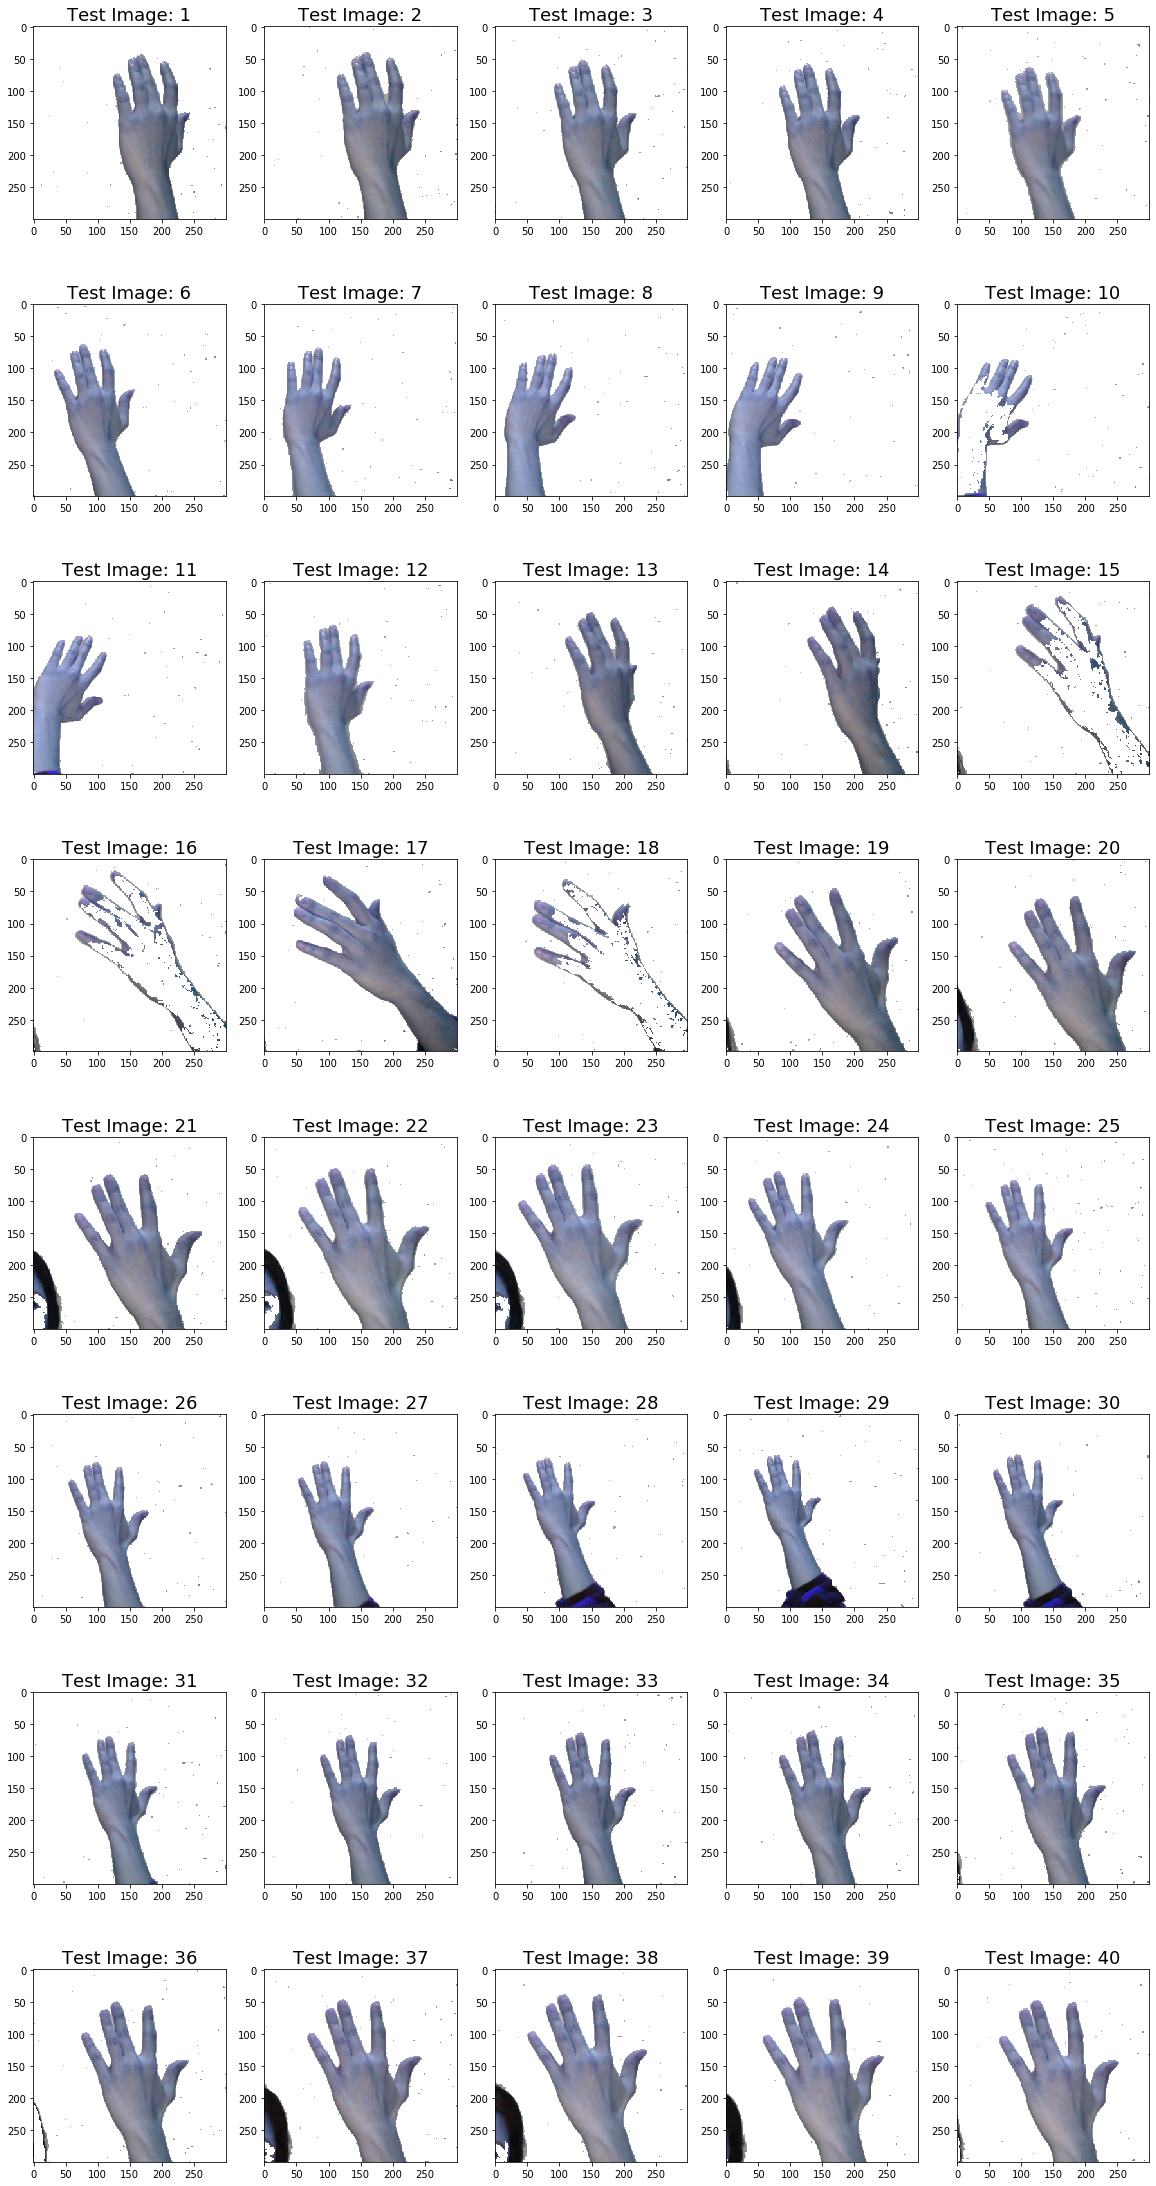

In [6]:
# Displaying the obtained test images for class 0 : paper
plt.subplots(8,5,figsize=(20,40))

# Iterating through the 40 images
for image in np.arange(1,41):
    
    # Plotting the image    
    plt.subplot(8,5,image)
    plt.imshow(globals()[f'paper_{image}'])
    
    # Adding a title
    plt.title(f'Test Image: {image}', fontsize=18)
    
# Show the images 
plt.show()

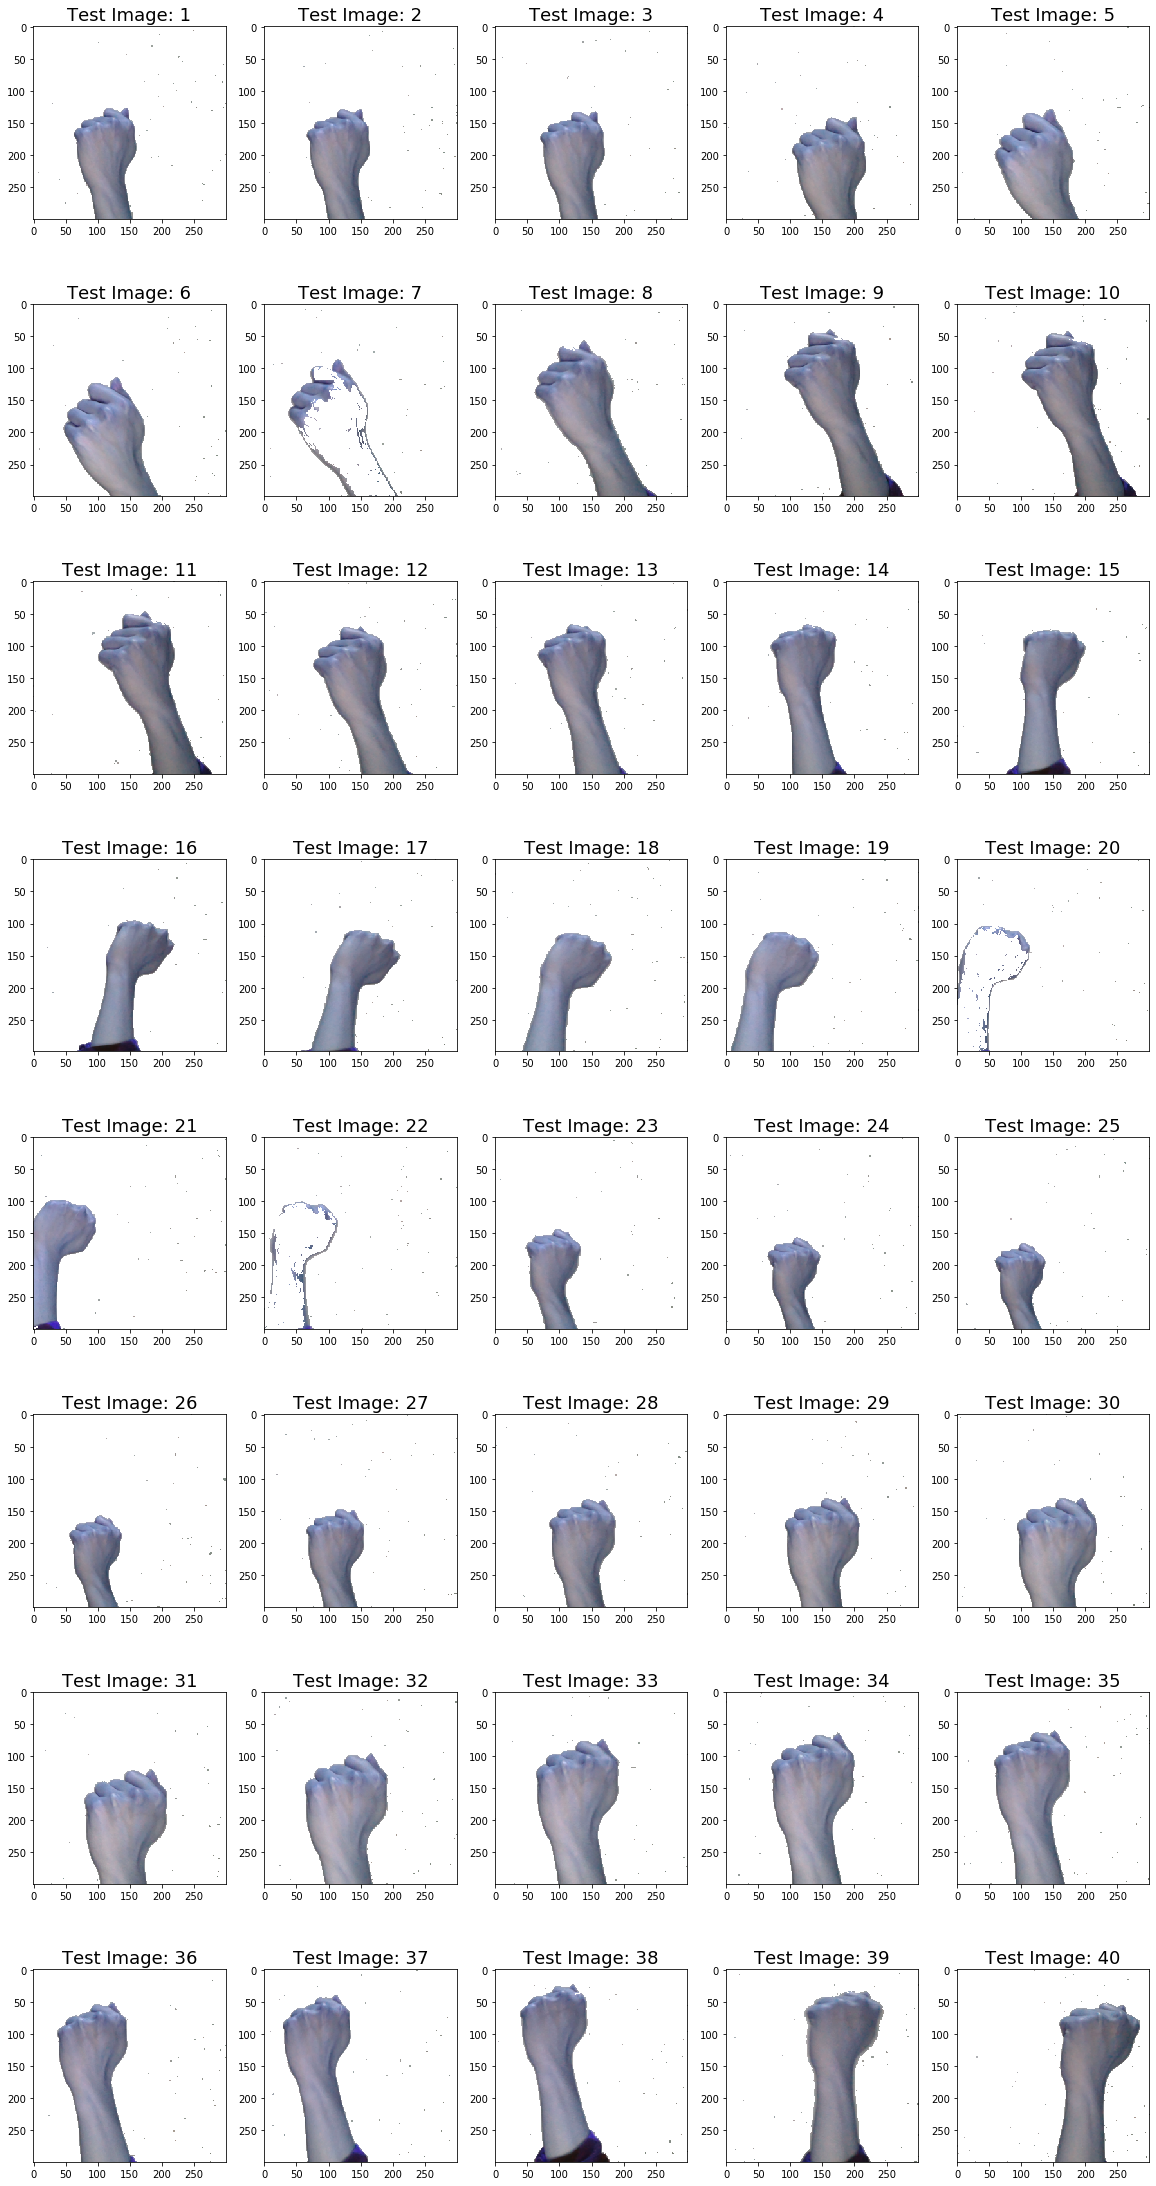

In [7]:
# Displaying the obtained test images for class 1 : rock
plt.subplots(8,5,figsize=(20,40))

# Iterating through the 40 images
for image in np.arange(1,41):
    
    # Plotting the image
    plt.subplot(8,5,image)
    plt.imshow(globals()[f'rock_{image}'])
        
    # Adding a title
    plt.title(f'Test Image: {image}', fontsize=18)
    
# Show the images 
plt.show()

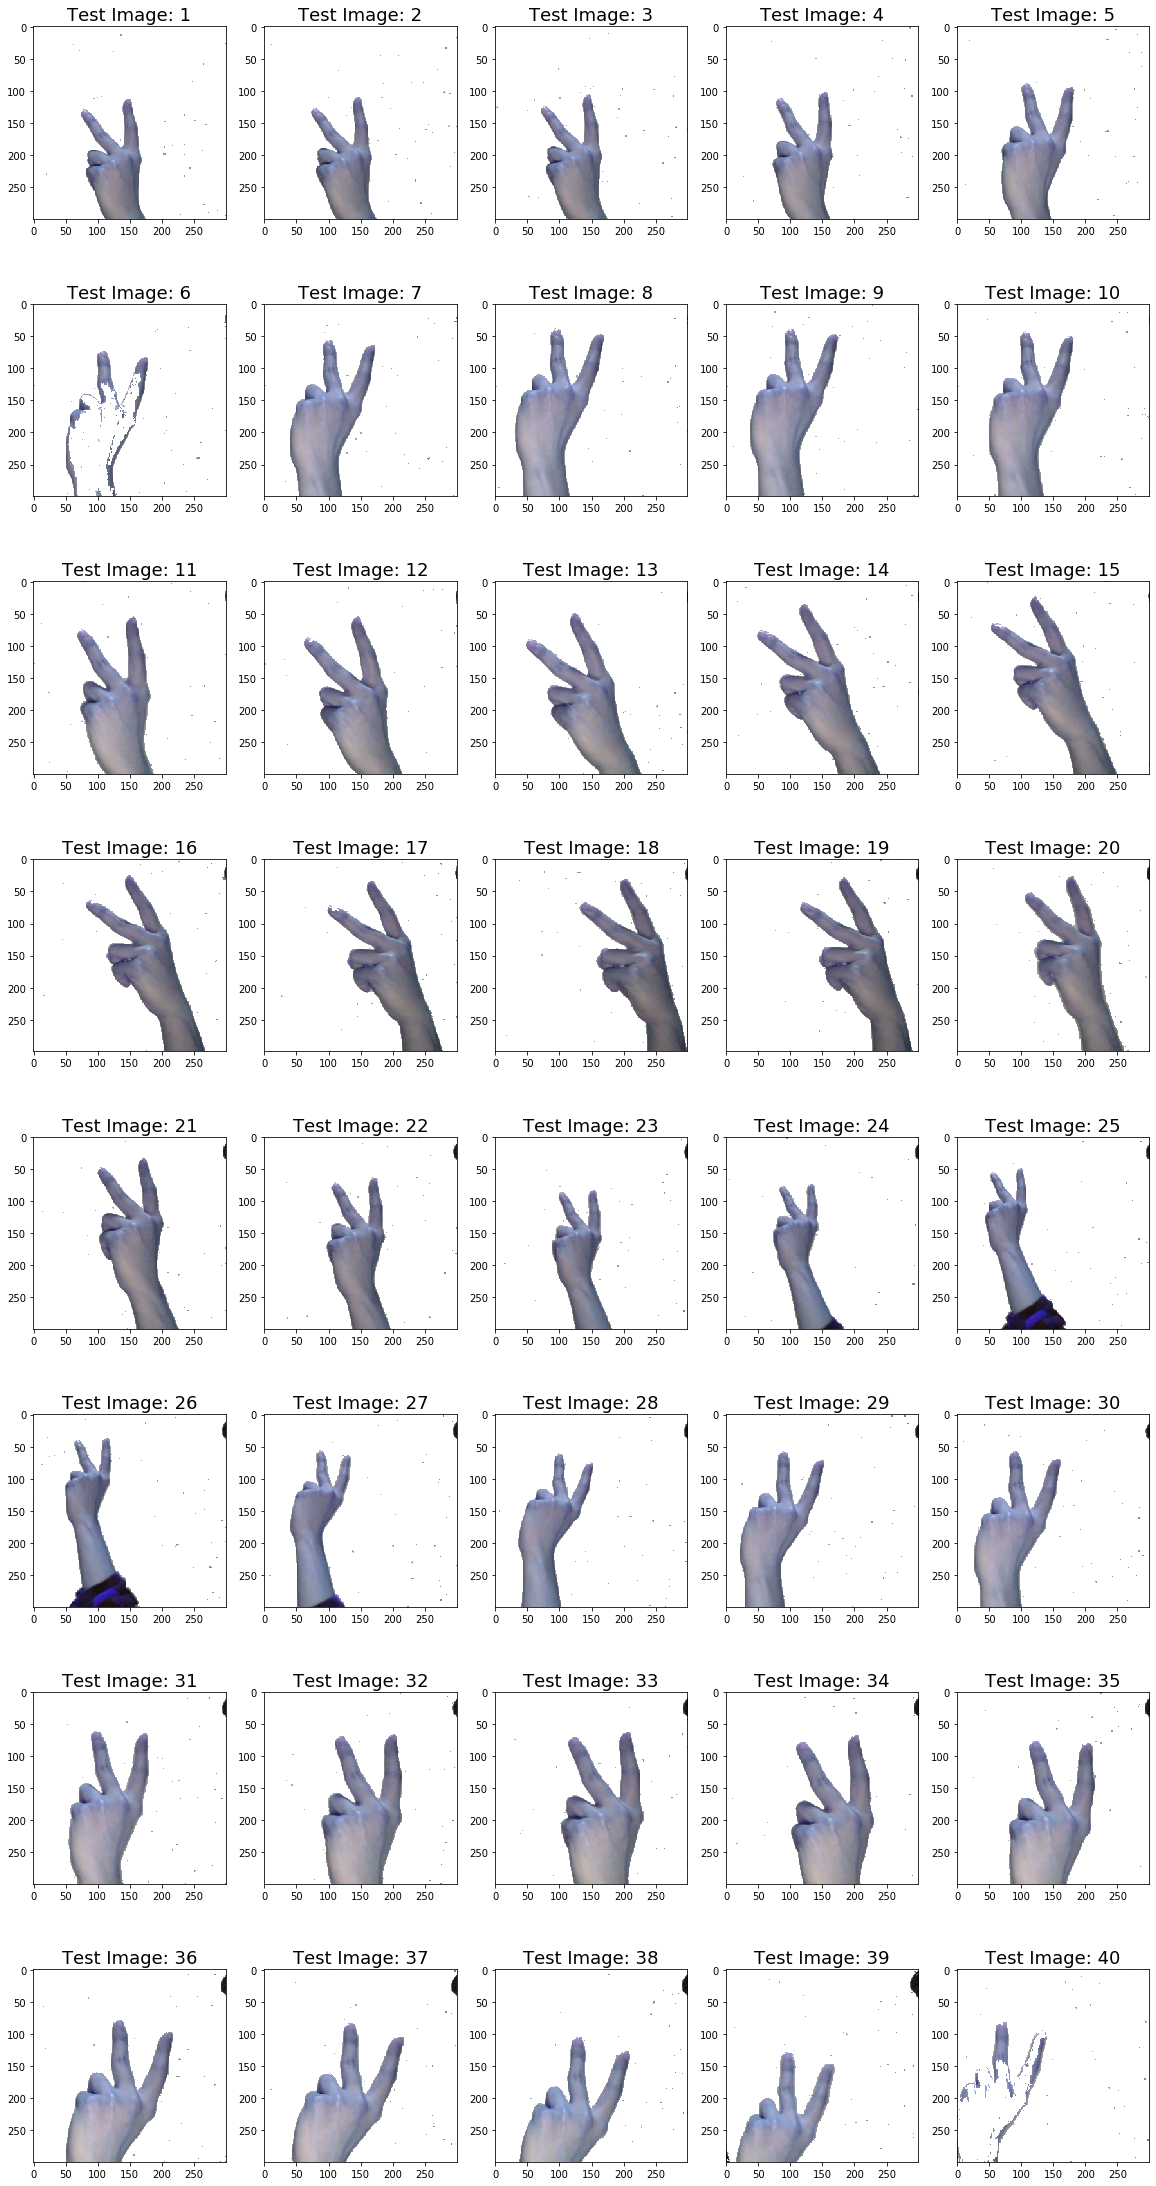

In [8]:
# Displaying the obtained test images for class 2 : scissors
plt.subplots(8,5,figsize=(20,40))

# Iterating through the 40 images
for image in np.arange(1,41):
    
    # Plotting the image
    plt.subplot(8,5,image)
    plt.imshow(globals()[f'scissors_{image}'])
        
    # Adding a title
    plt.title(f'Test Image: {image}', fontsize=18)
    
# Show the images 
plt.show()

In [9]:
# Creating a df of the 'true_classes' and model predictions for all 120 images for readability

# Turning the lists to pd.Series
pd_true = pd.Series(true_classes)
pd_predict = pd.Series(vgg16_predictions)

# Combining both lists into a df
prediction_summary = pd.concat([pd_true, pd_predict], axis=1)

# Adding column names 
prediction_summary.columns = ['true_classes','vgg16_predictions']

# Display the df
prediction_summary

,true_classes,vgg16_predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
115,2,2
116,2,2
117,2,2
118,2,2


In [10]:
# Getting the accuracy score
print(f'Accuracy Score: {accuracy_score(true_classes, vgg16_predictions)}')

Accuracy Score: 0.9


Thus, the VGG16 model achieved 90% accuracy when predicting whether new images taken in real-time were rock, paper or scissor hand-gestures. 

In [12]:
# Displaying the classification report for the validation set
print('vgg16_model Classification Report\n \n', classification_report(true_classes, vgg16_predictions, 
                                                                      target_names=CLASSES_LIST),'\n')

vgg16_model Classification Report
 
               precision    recall  f1-score   support

       paper       1.00      0.82      0.90        40
        rock       0.77      1.00      0.87        40
    scissors       1.00      0.88      0.93        40

    accuracy                           0.90       120
   macro avg       0.92      0.90      0.90       120
weighted avg       0.92      0.90      0.90       120
 



Based on the precision, recall and f1 scores, the model was most successful when predicting scissors, achieving the highest scores. 

Scores were lowest when predicting the rock class and may demonstrate a slight higher tendancy for the model to classify a new image as a rock when taken from webcam in real-time. 

These patterns are also visible in the normalized and non-normalized confusion matrices below. 

In [14]:
# Creating a non-normalized confusion matrix for the validation set
vgg16_matrix = pd.DataFrame(confusion_matrix(true_classes, vgg16_predictions), 
                            columns=predicted_labels, index=true_labels)
# Show it 
vgg16_matrix

,Predicted paper,Predicted rock,Predicted scissors
True paper,33,7,0
True rock,0,40,0
True scissors,0,5,35


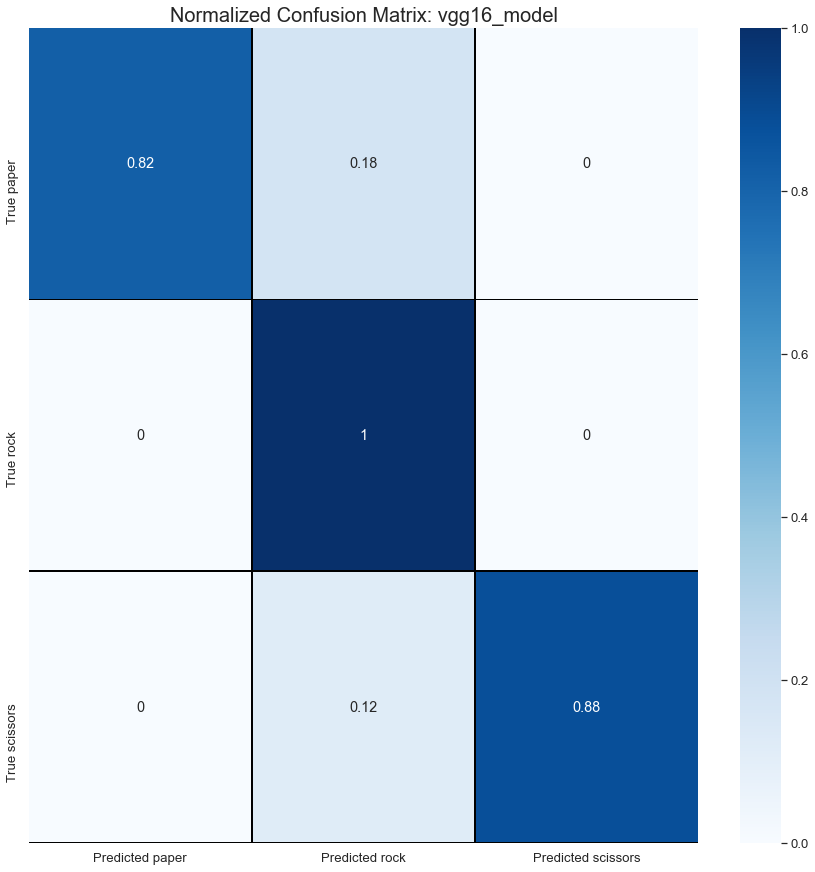

In [15]:
# Plotting the normalized confusion matrix (proportion of predictions by class) as a heatmap

# Larger fontsize
sns.set(font_scale=1.2)

# Creating the figure
plt.figure(figsize=(15,15))
sns.heatmap(round(vgg16_matrix/vgg16_matrix.sum(axis=1)[:,np.newaxis],2),
            # Formatting the figure
            cmap='Blues', annot=True, linewidths=.5, linecolor='black')

# Formatting the title
plt.title('Normalized Confusion Matrix: vgg16_model', fontsize=20)

# Display the heatmap
plt.show()

Overall the VGG16 CNN that we trained on RPS images in notebook `rps_VGG16.ipynb` seems to do well when classifying new images taken from the webcam in real-time! 

In the next notebook `rps_against_cpu.ipynb` we will **use the model to allow us to play a game of RPS against the computer.** 